# NSF Computer and Information Science and Engineering (CISE) 

- `05050000`: Division of Computer and Network Systems (CNS)
- `05010000`: Division of Computing and Communication Foundations (CCF)
- `05020000`: Division of Information and Intelligent Systems (IIS)
- `05090000`: Office of Advanced Cyberinfrastructure (OAC)

In [2]:
import os,sys,json
import core.coworknet, core.nsf_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
from datetime import datetime
from collections import Counter

In [3]:
grant_type = ["Standard Grant", "Continuing grant"] # draw only these types
div_type = {
    "05050000": "Division of Computer and Network Systems (CNS)",
    "05010000": "Division of Computing and Communication Foundations (CCF)",
    "05020000": "Division of Information and Intelligent Systems (IIS)",
    "05090000": "Office of Advanced Cyberinfrastructure (OAC)"
}

In [4]:
def histogram_num_pis(data, years, orgcodes):
    plt.title("[NSF {}-{}] histogram - number of PIs".format(years[0], years[-1]))
    plt.ylabel("Number of grants")
    plt.xlabel("Number of PIs")
    pis = [d["num_pis"] for d in data.values() if d["org"] in orgcodes]
    counter_pis = Counter(pis)
    print(counter_pis)
    x = range(1, 10)
    y = [counter_pis[i] if i in counter_pis else 0 for i in x]
    plt.bar(x, y)

In [27]:
def plot_coauthor_heatmap_paper(pid):
    table, ts, te, G = core.coworknet.get_grant_coworknet_pis(pid)
    authors_sorted = sorted(G.nodes(data=True), key=lambda x: x[1]["paperCount"], reverse=True)
    authors_sorted = sorted(authors_sorted, key=lambda x: x[1]["pi"], reverse=True)
#     print(authors)
    authors_dict = {k:d for k, d in authors_sorted}
    authors = authors_dict.keys()
    if len(table) == 0:
        no_publications.append(pid)
        return
    
    convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")
    
    # calculate coauthorship by papar
    times = sorted([convert_t(v["date"]) for v in table.values()])
    dates = {convert_t(v["date"]):v["authors"] for v in table.values()}
    dates_ingrant = [convert_t(v["date"]) for v in table.values() if v["type"]]
    coauthored = np.array([[2 if ts <= t and t <= te and a in dates[t] else (1 if a in dates[t] else 0) for t in times] for a in authors])
    coauthored_ingrant = np.array([[1 if t in dates_ingrant and a in dates[t] else 0 for t in times] for a in authors])
    
    fig, ax = plt.subplots(figsize=(len(times)/5,len(authors)/2))
    im = ax.imshow(coauthored, cmap="GnBu", vmin=0)

    ax.set_xticks(np.arange(len(times)))
    ax.set_yticks(np.arange(len(authors)))
    ax.set_xticklabels([datetime.strftime(t, "%Y-%m-%d") for t in times])
    ax.set_yticklabels(["{} {} ({})".format("*" if authors_dict[a]["pi"] else "", a, authors_dict[a]["paperCount"]) for a in authors])
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    for i in range(len(authors)):
        for j in range(len(times)):
            label = "*" if coauthored_ingrant[i, j] > 0 else ""
            text = ax.text(j, i, label, ha="center", va="center", color="black")

    ax.set_title("{} ({}~{})".format(pid, datetime.strftime(ts, "%Y-%m-%d"), datetime.strftime(te, "%Y-%m-%d")))
    plt.show()
    
    fig = plt.figure(figsize=(9,3))
#     print(G.edges.data())
#     pos = nx.fruchterman_reingold_layout(G)
    pos = nx.spring_layout(G,k=0.20,iterations=20)
    for idx, nxtype in enumerate(["pre-grant", "grant", "post-grant"]):
        e_colors = []
        n_colors = []
        weight = []
        for v,data in G.nodes.data():
            n_colors.append(cm.get_cmap("YlOrRd", 100)(100 if data["pi"] else 50)) 
        for u,v,d in G.edges.data():
            if nxtype == "pre-grant":
                e_colors.append("black" if convert_t(d["date"]) < ts else "white")
                weight.append(np.sqrt(len(G[u][v])) if convert_t(d["date"]) < ts else 0)
            if nxtype == "grant":
                e_colors.append("black" if ts <= convert_t(d["date"]) and convert_t(d["date"]) <= te else "white")
                weight.append(np.sqrt(len(G[u][v])) if ts <= convert_t(d["date"]) and convert_t(d["date"]) <= te else 0)
            if nxtype == "post-grant":
                e_colors.append("black" if te < convert_t(d["date"]) else "white")
                weight.append(np.sqrt(len(G[u][v])) if te < convert_t(d["date"]) else 0)
        fig.add_subplot(1,3,1+idx).set_title(nxtype)
        degree = [np.sqrt(v[1] * 100) for v in nx.degree(G)]
        nx.draw(G, pos, node_size=degree, node_color=n_colors, edge_alpha=e_colors, width=weight)
    
    

In [28]:
data = {}
years = [2004]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"] == code and v["year"] == y]))

[2004]
Total number of grants 10212
Division of Computer and Network Systems (CNS) 405
Division of Computing and Communication Foundations (CCF) 332
Division of Information and Intelligent Systems (IIS) 362
Office of Advanced Cyberinfrastructure (OAC) 53


In [29]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

243 grants with 2 PIs


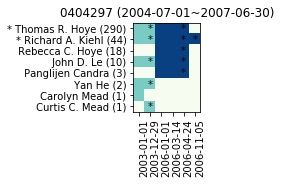

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


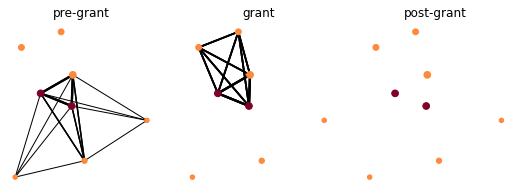

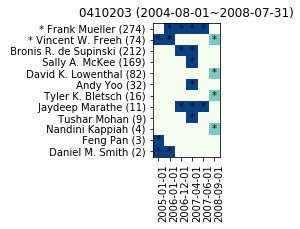

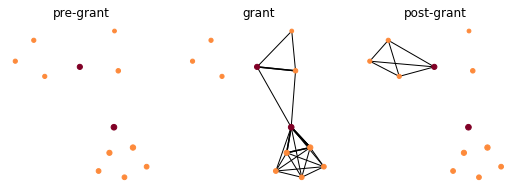

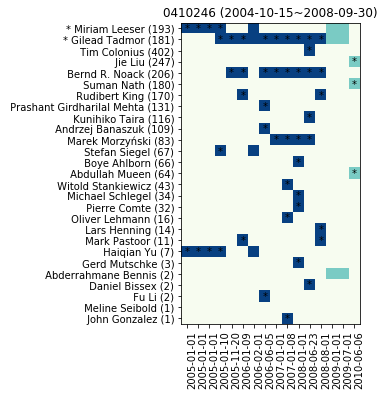

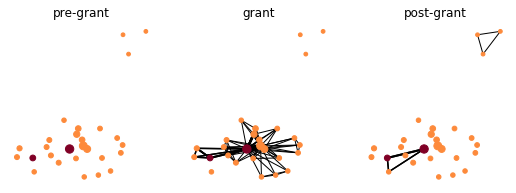

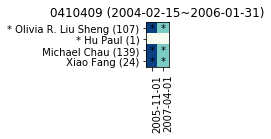

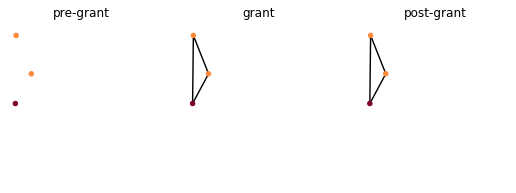

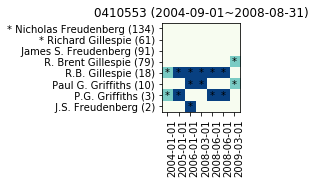

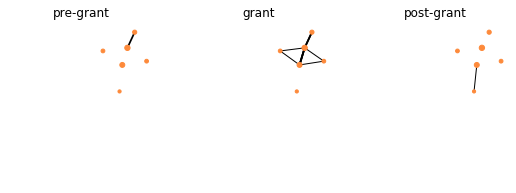

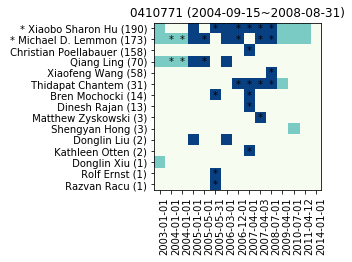

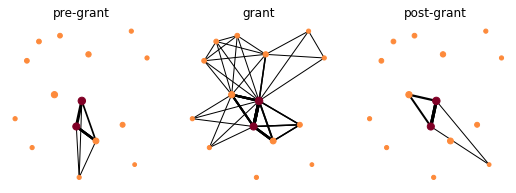

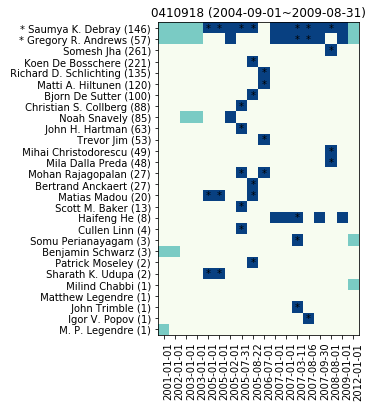

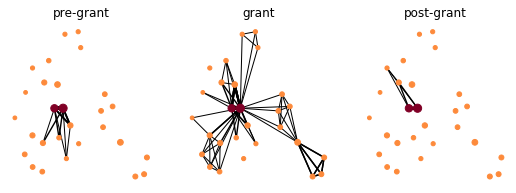

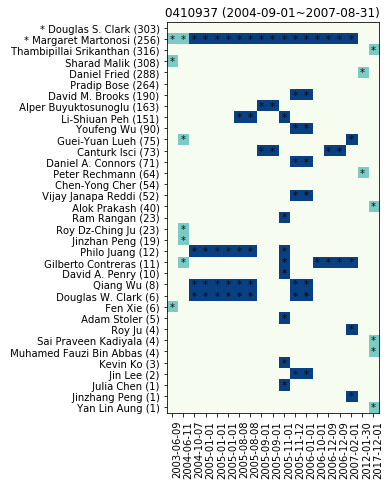

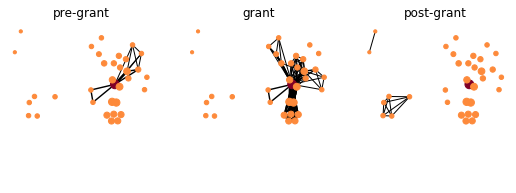

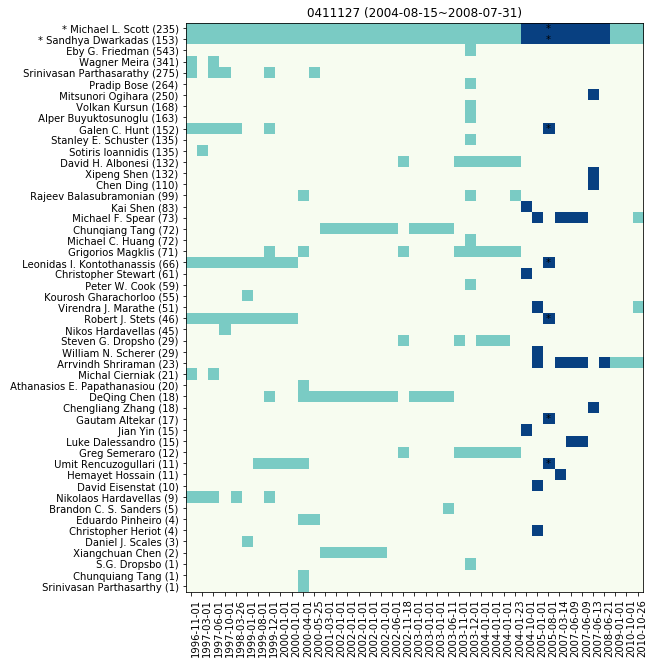

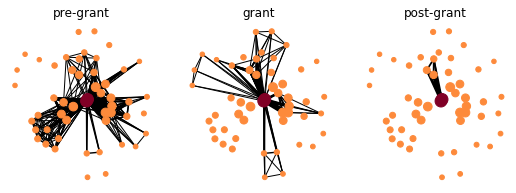

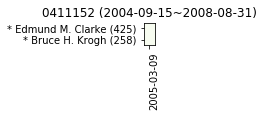

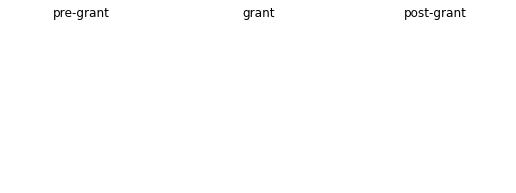

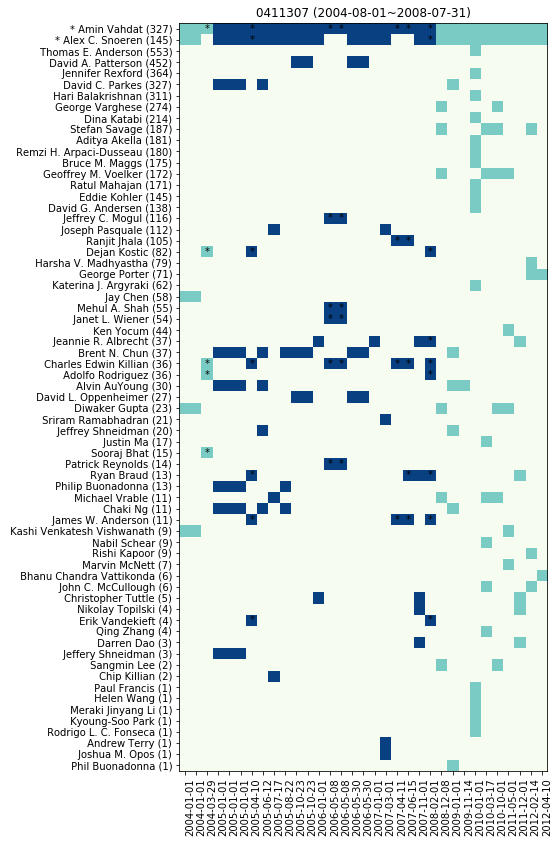

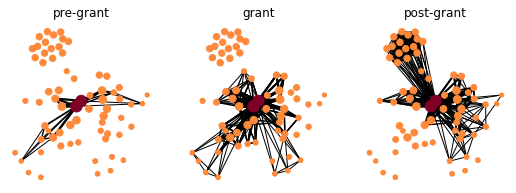

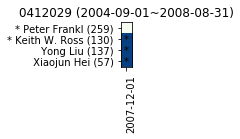

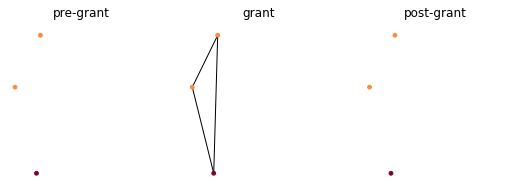

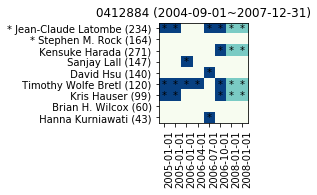

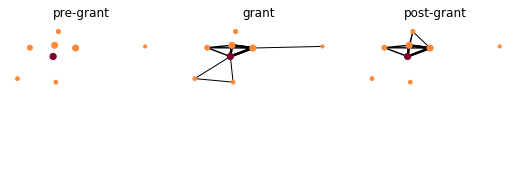

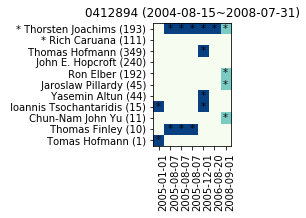

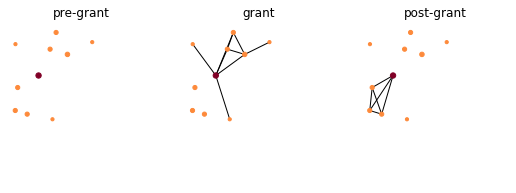

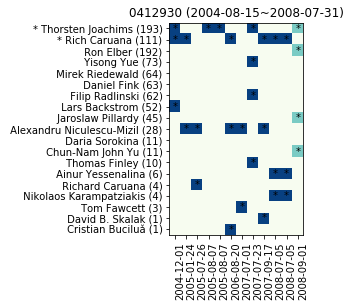

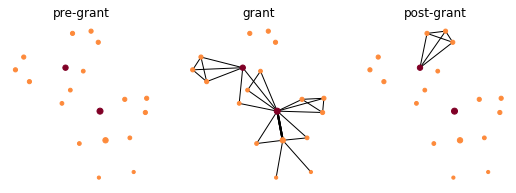

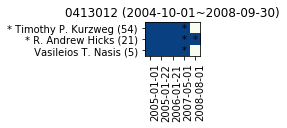

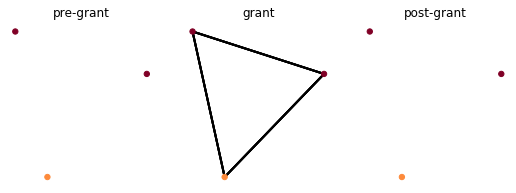

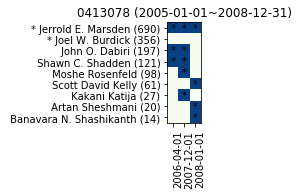

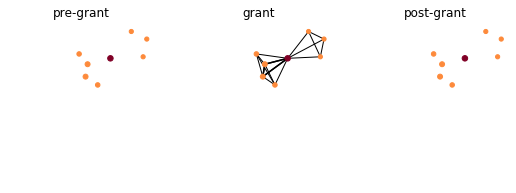

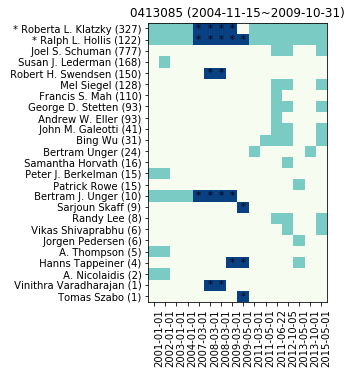

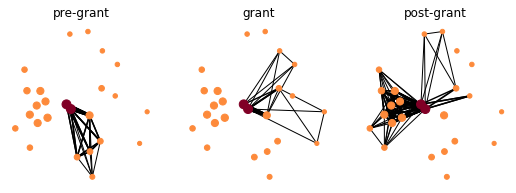

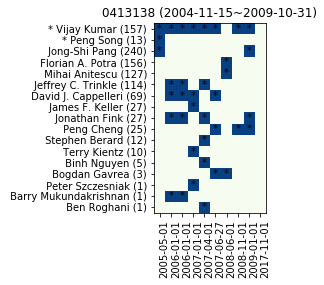

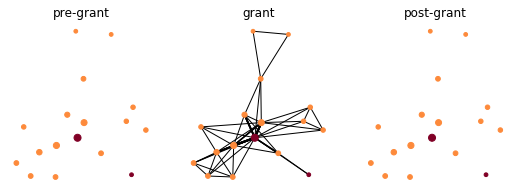

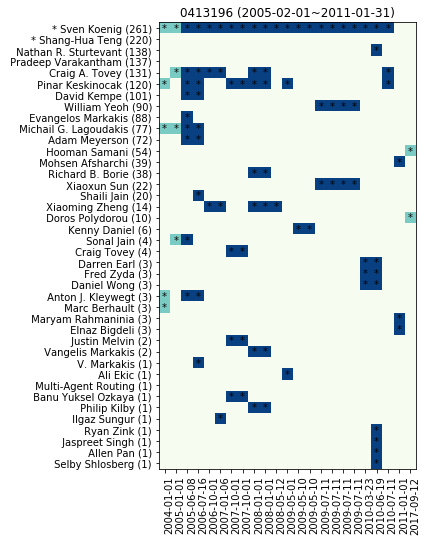

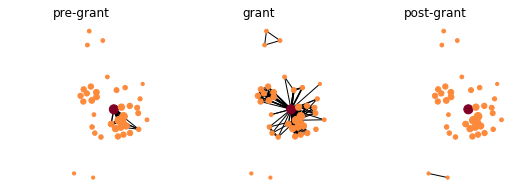

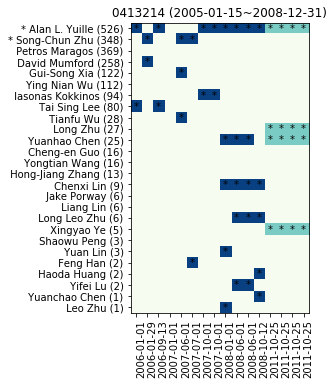

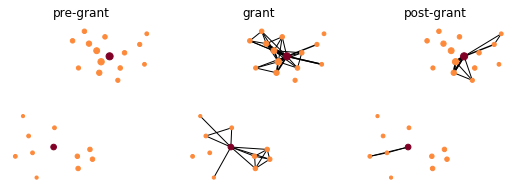

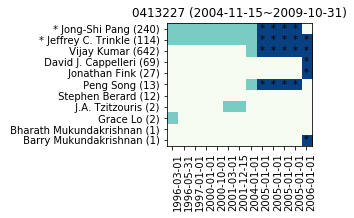

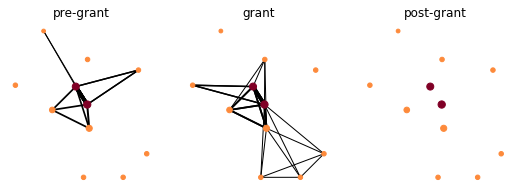

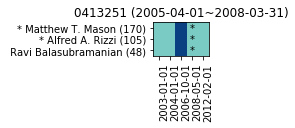

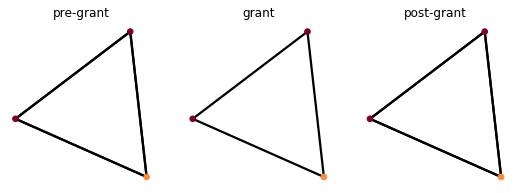

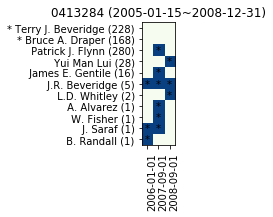

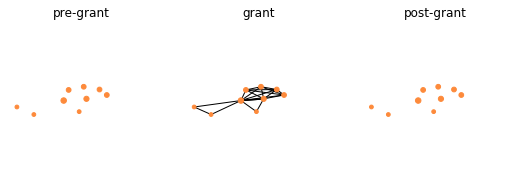

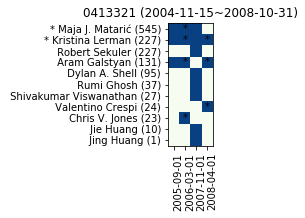

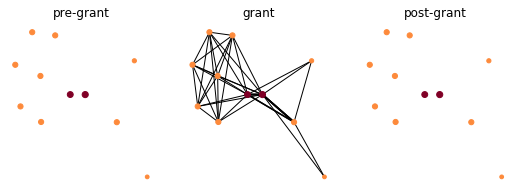

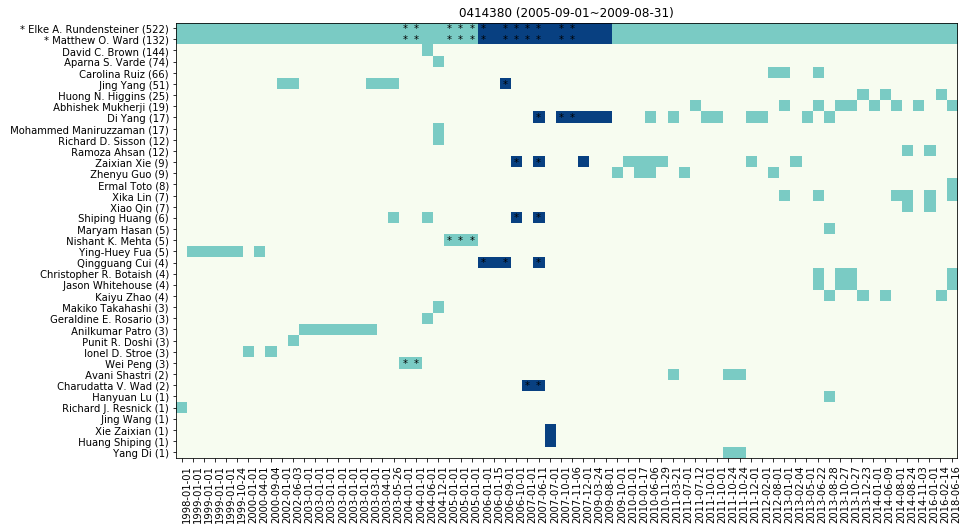

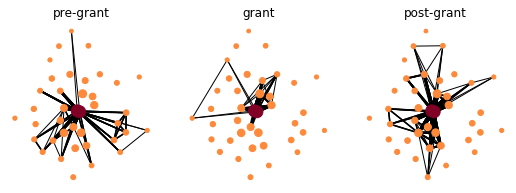

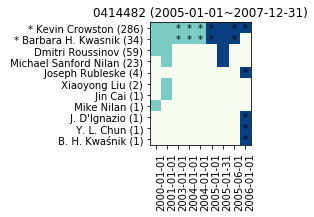

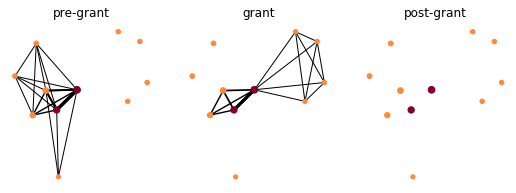

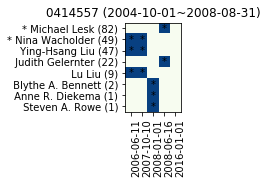

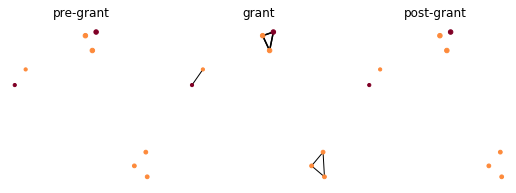

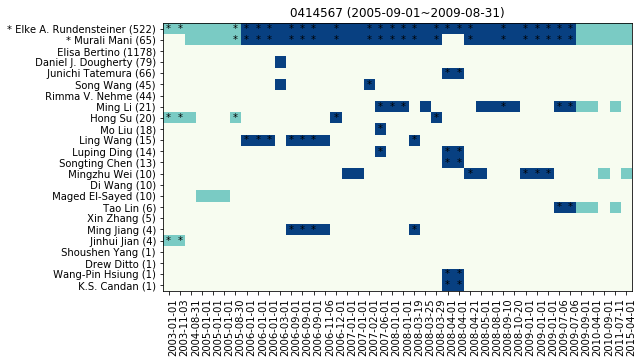

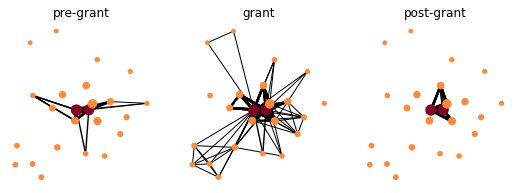

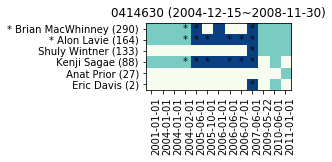

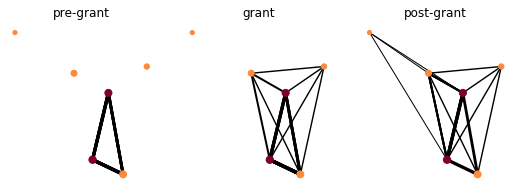

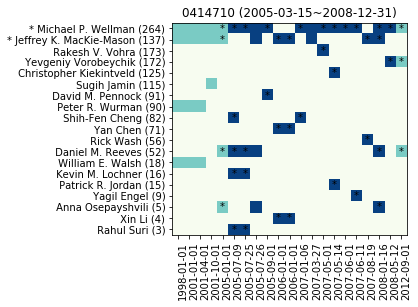

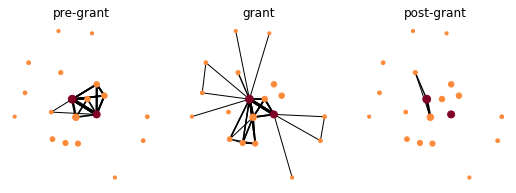

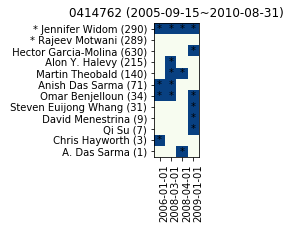

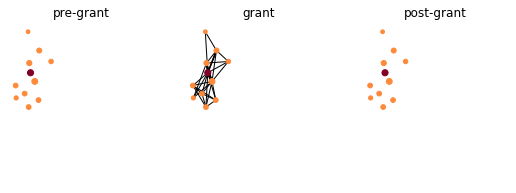

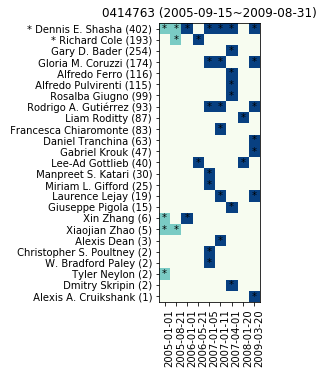

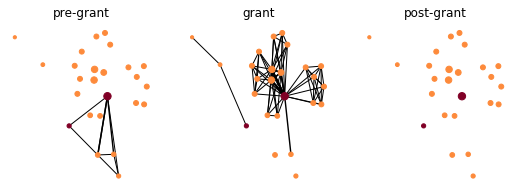

In [30]:
no_publications = []
for gid in grant_list[:50]:
    plot_coauthor_heatmap_paper(gid)

In [31]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 5]
print(len(grant_list), "grants with 5 PIs")

83 grants with 5 PIs


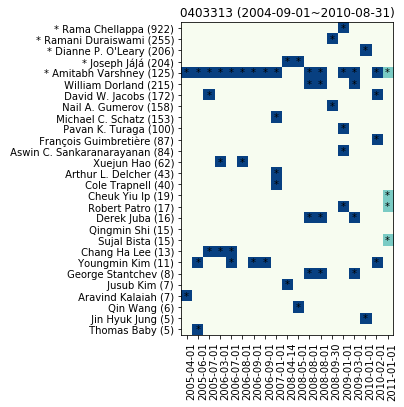

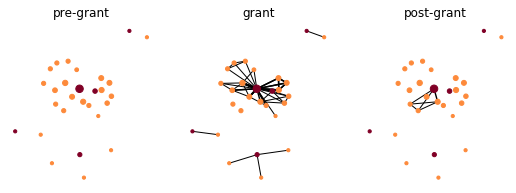

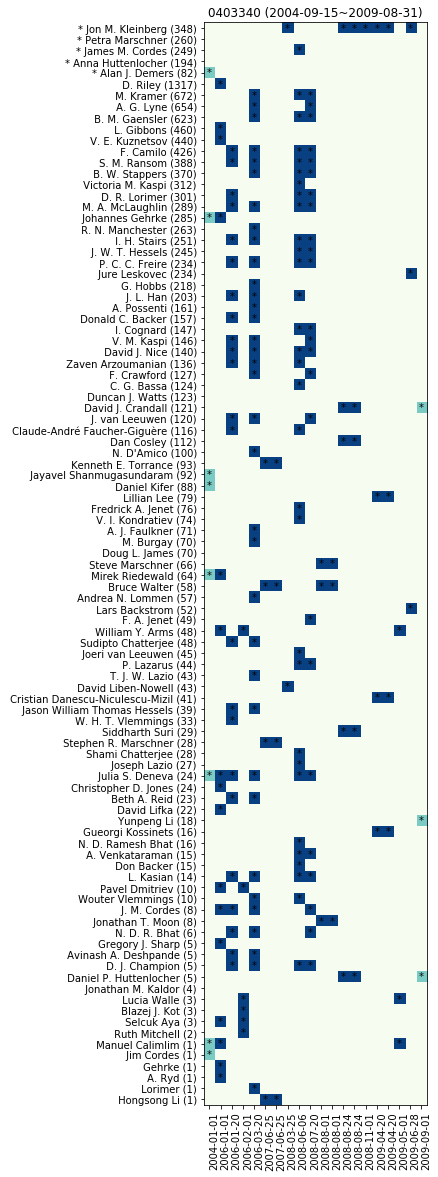

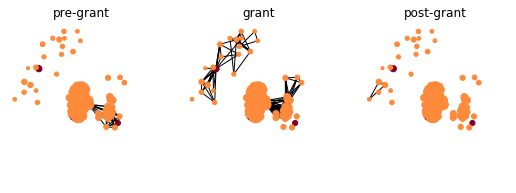

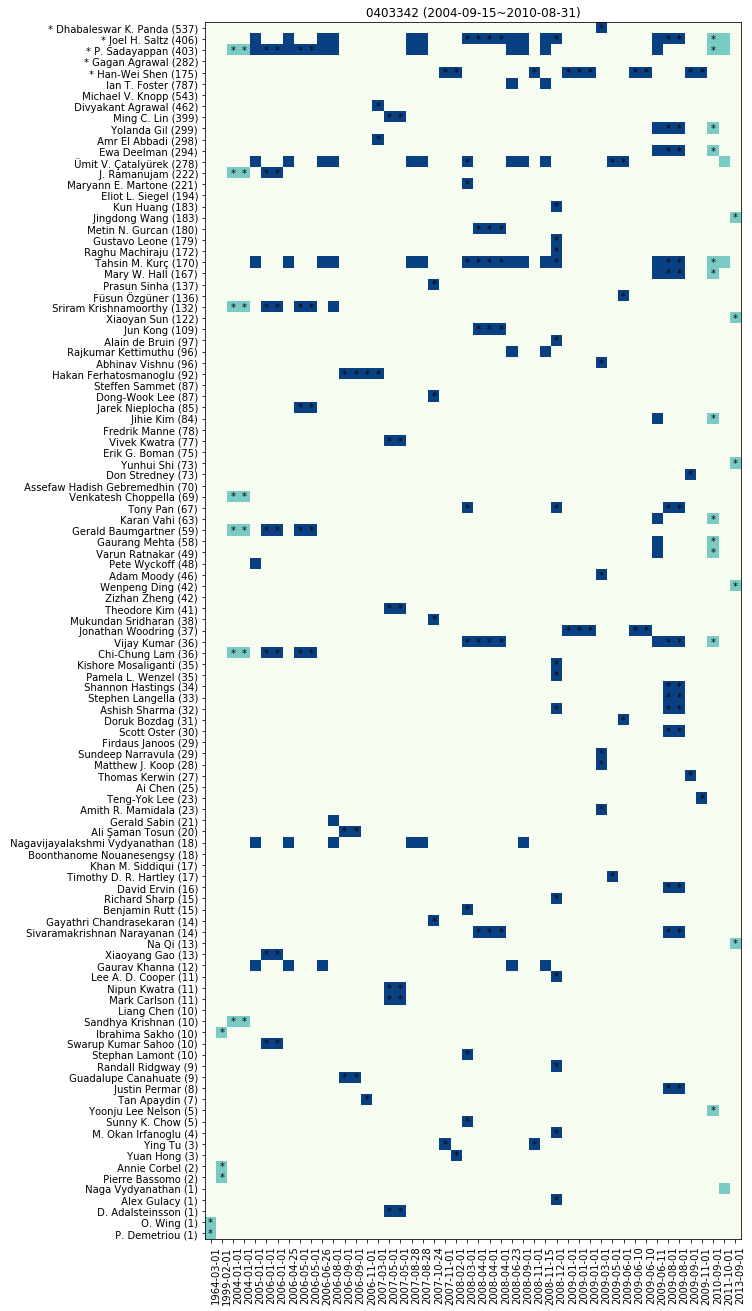

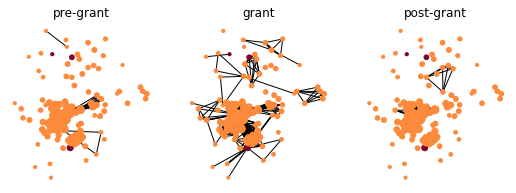

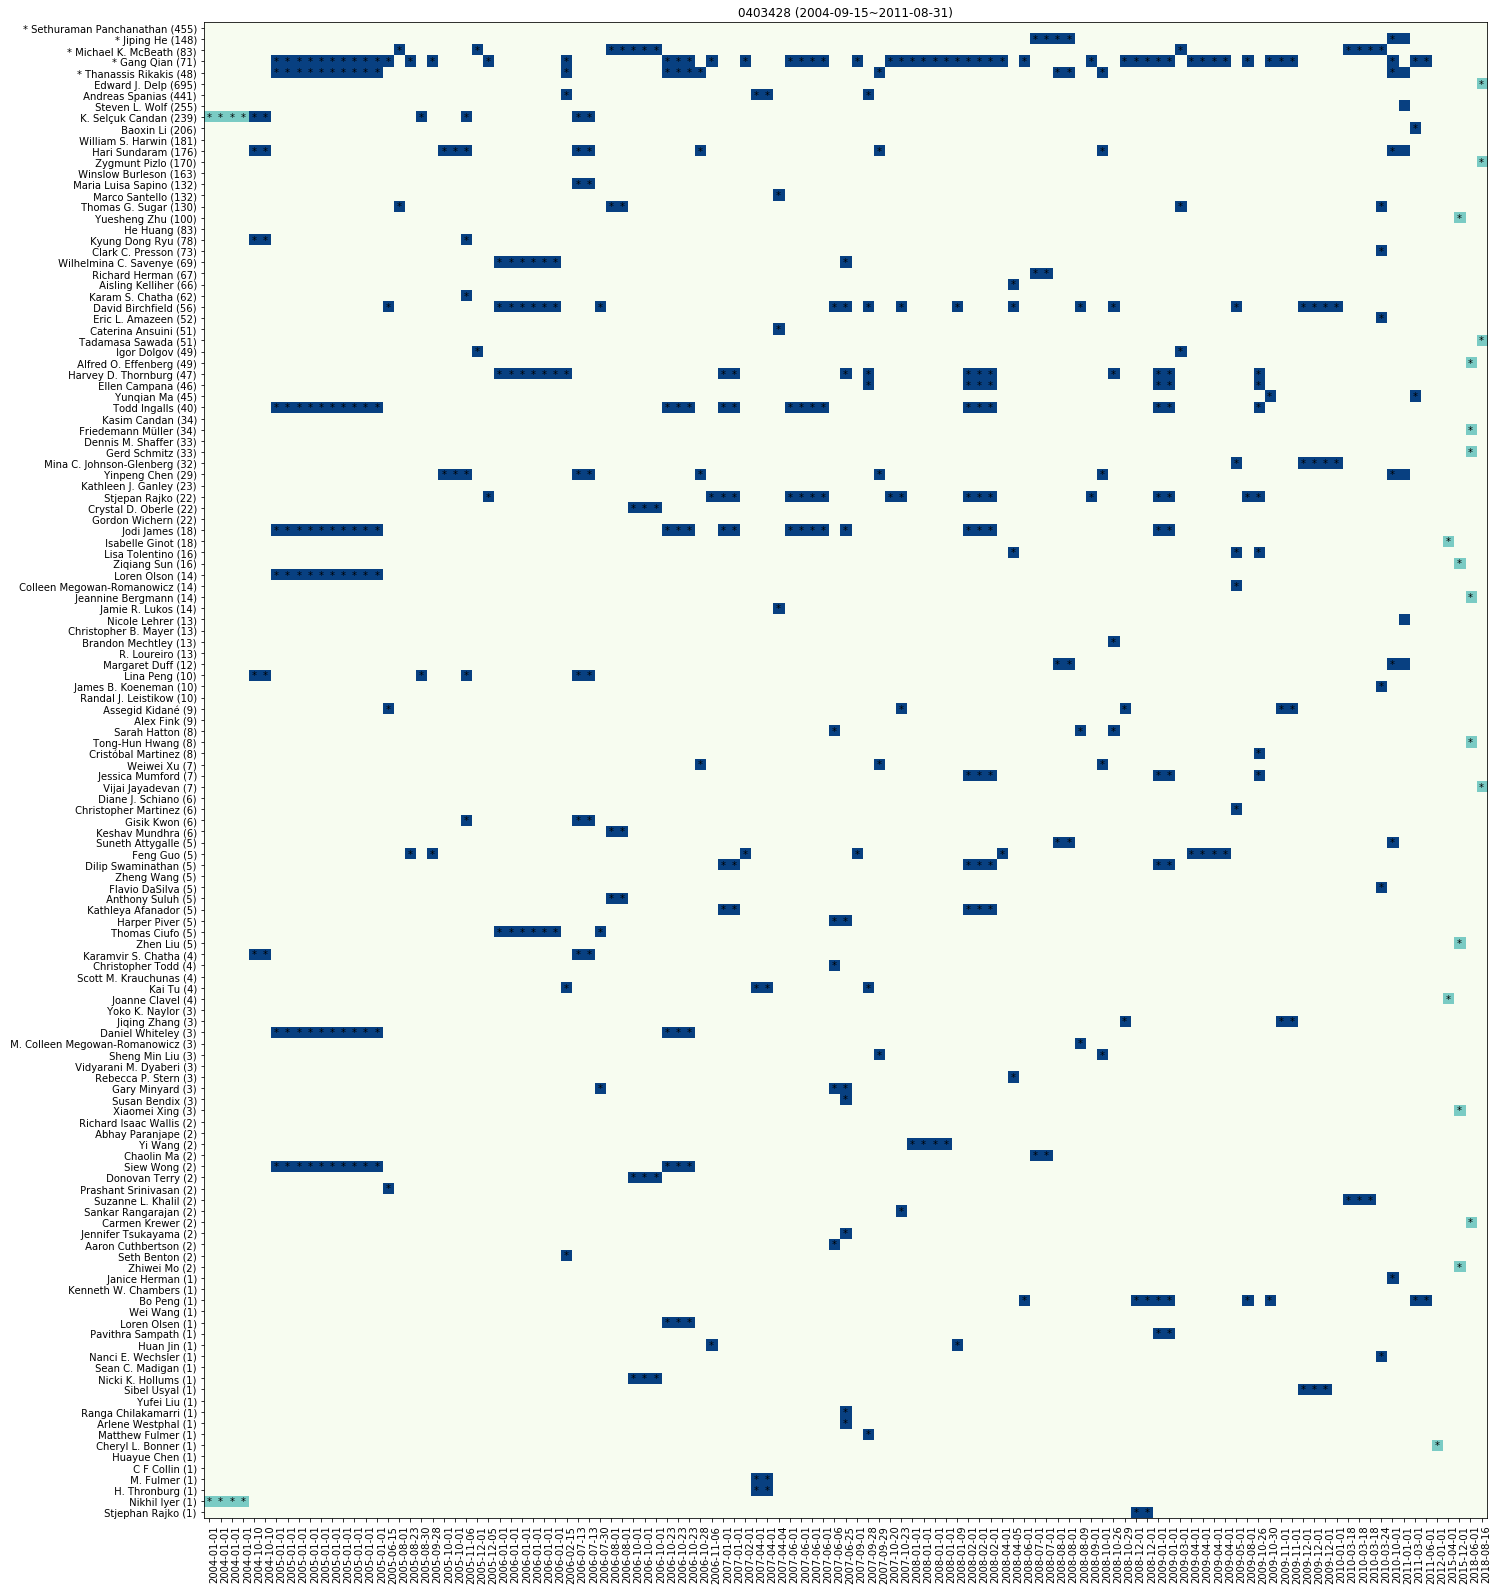

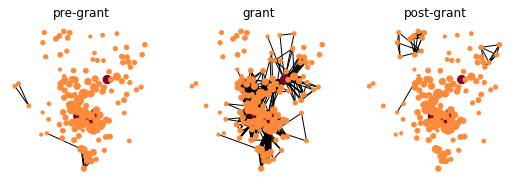

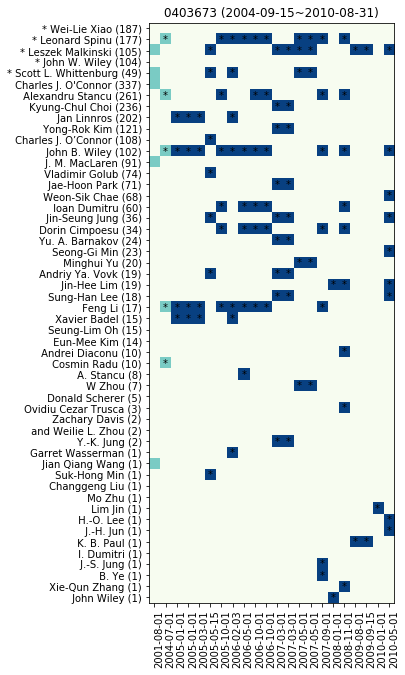

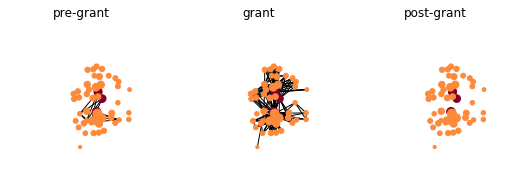

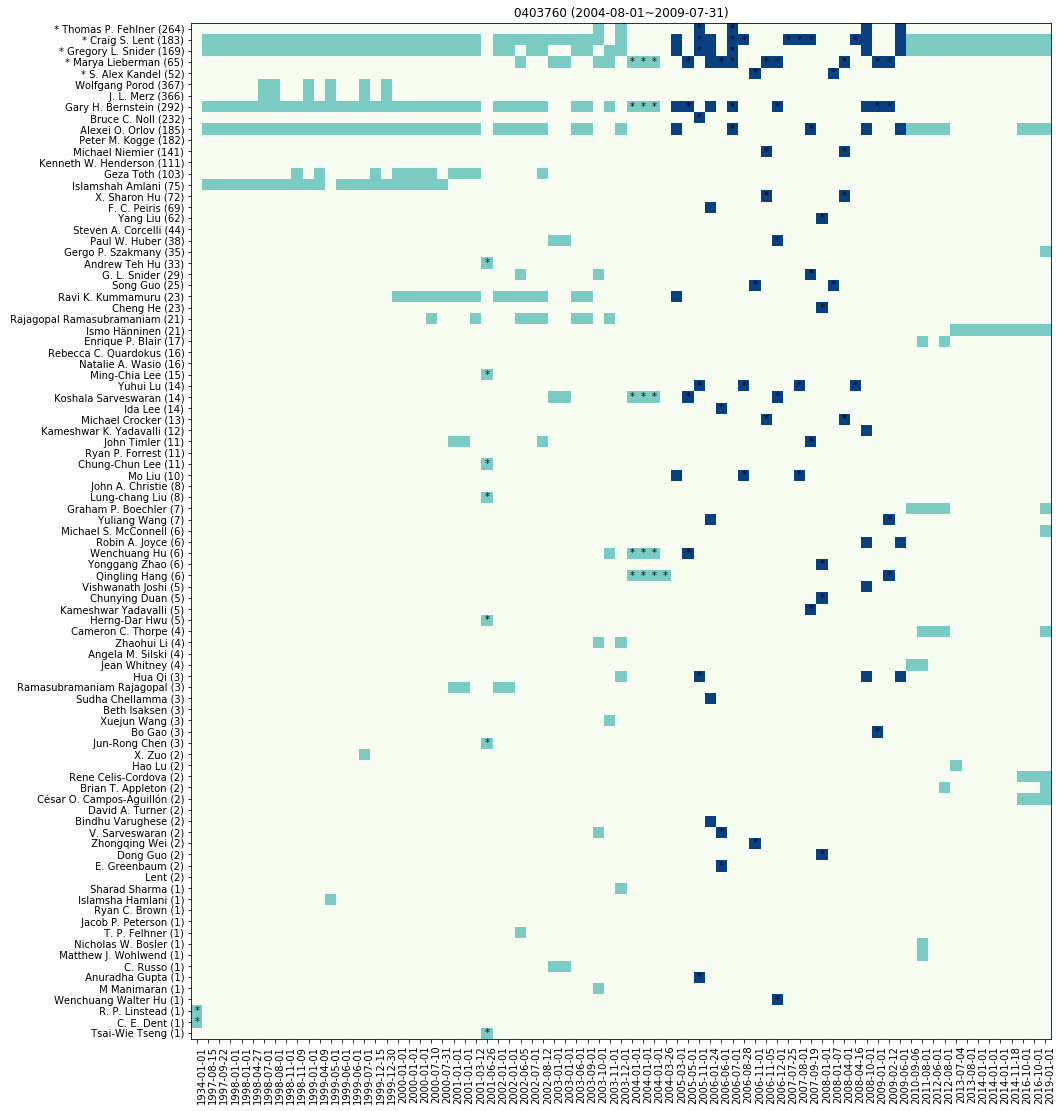

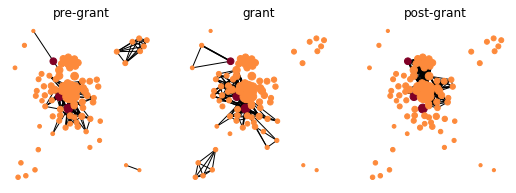

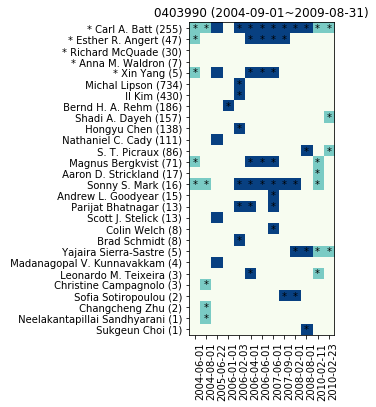

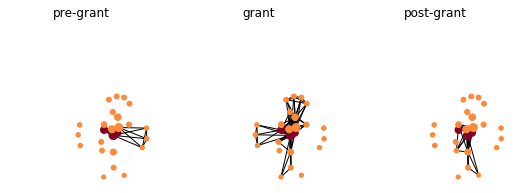

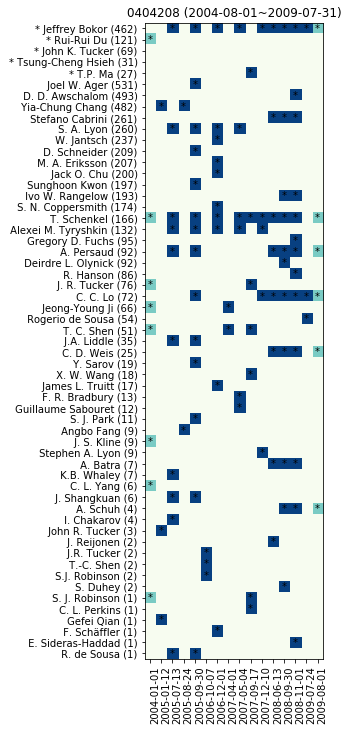

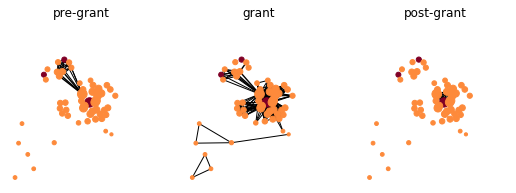

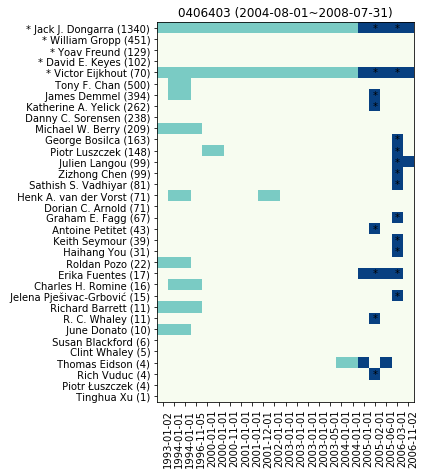

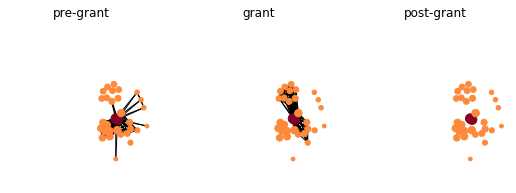

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26446 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20803 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 26446 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/mi

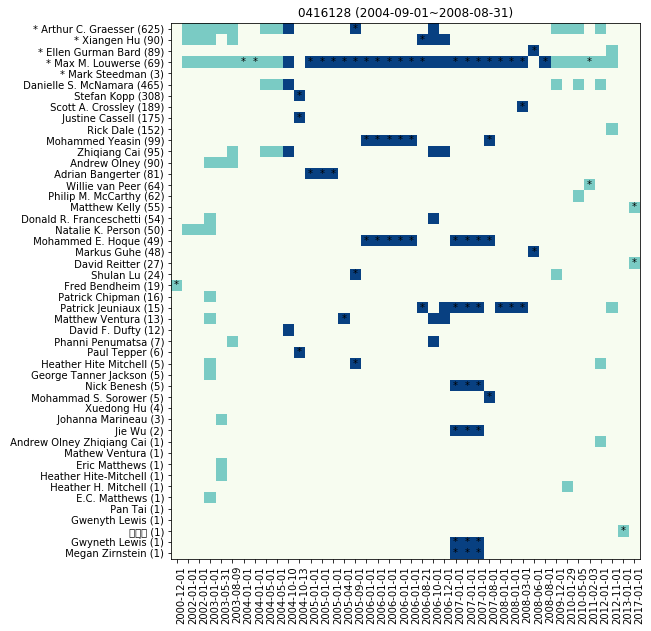

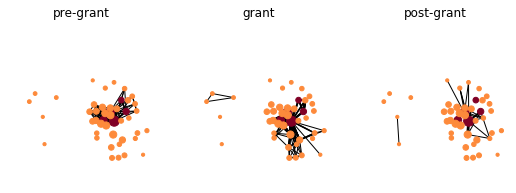

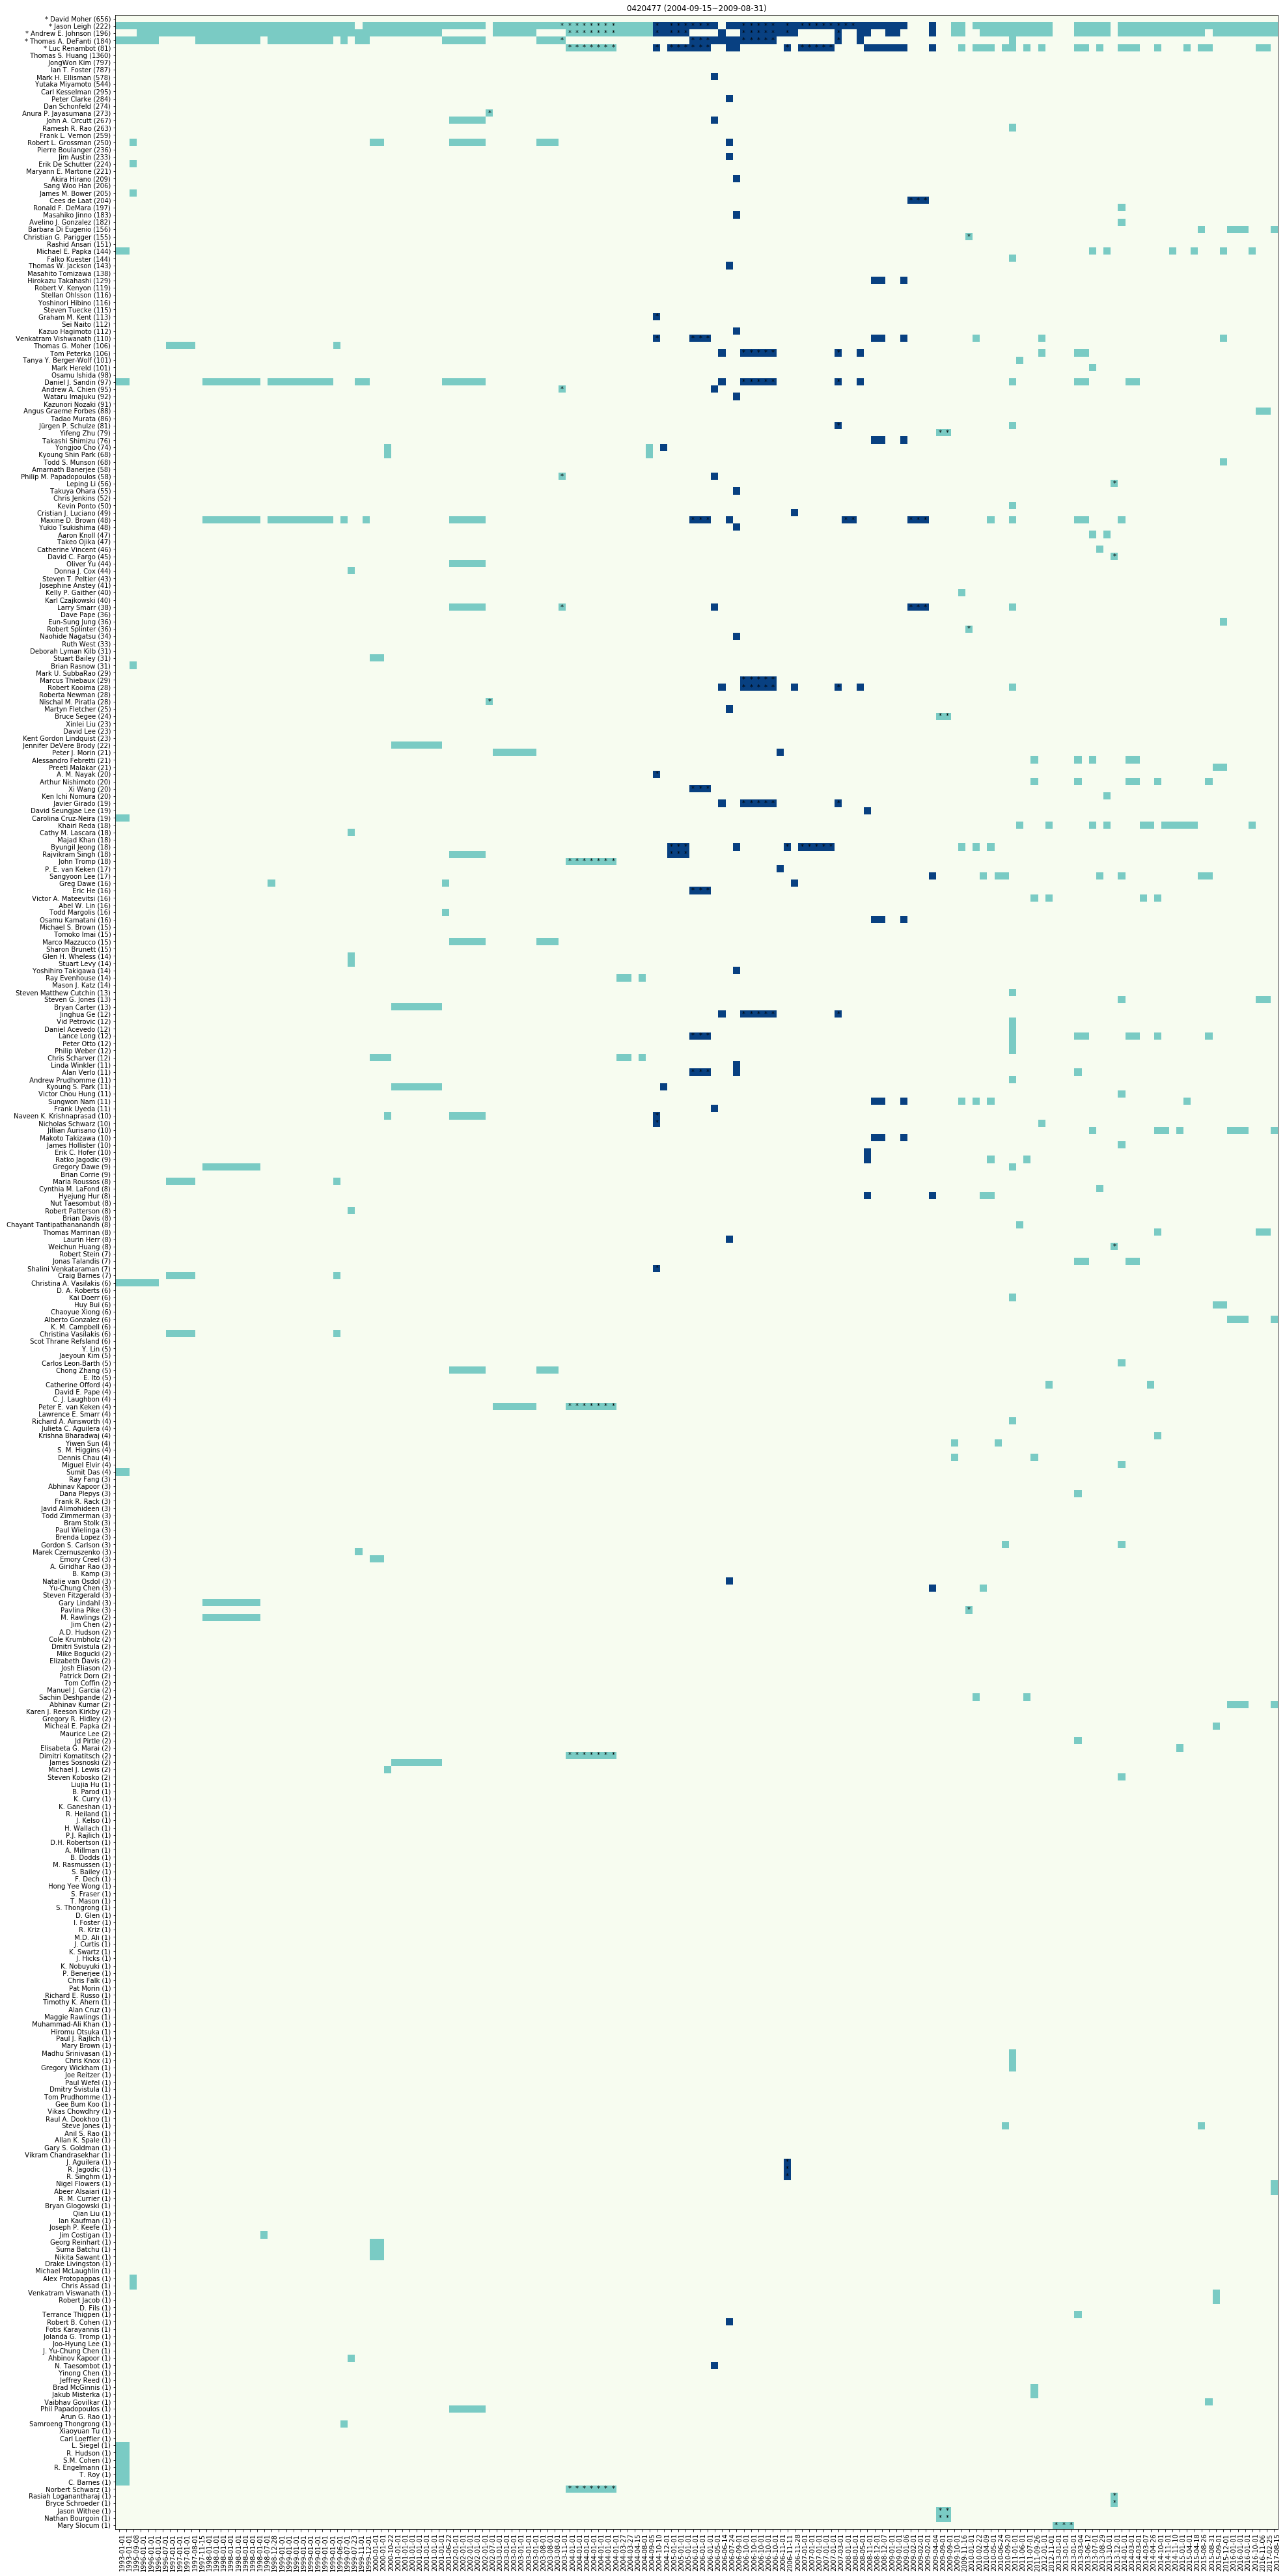

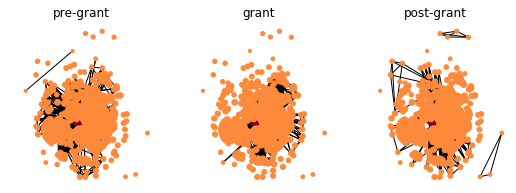

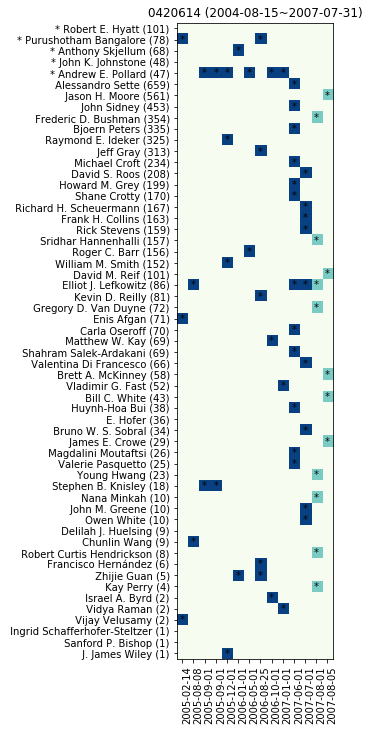

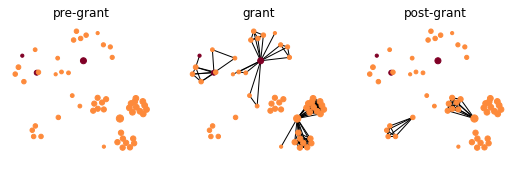

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20142 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21517 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 38534 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 37326 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/User

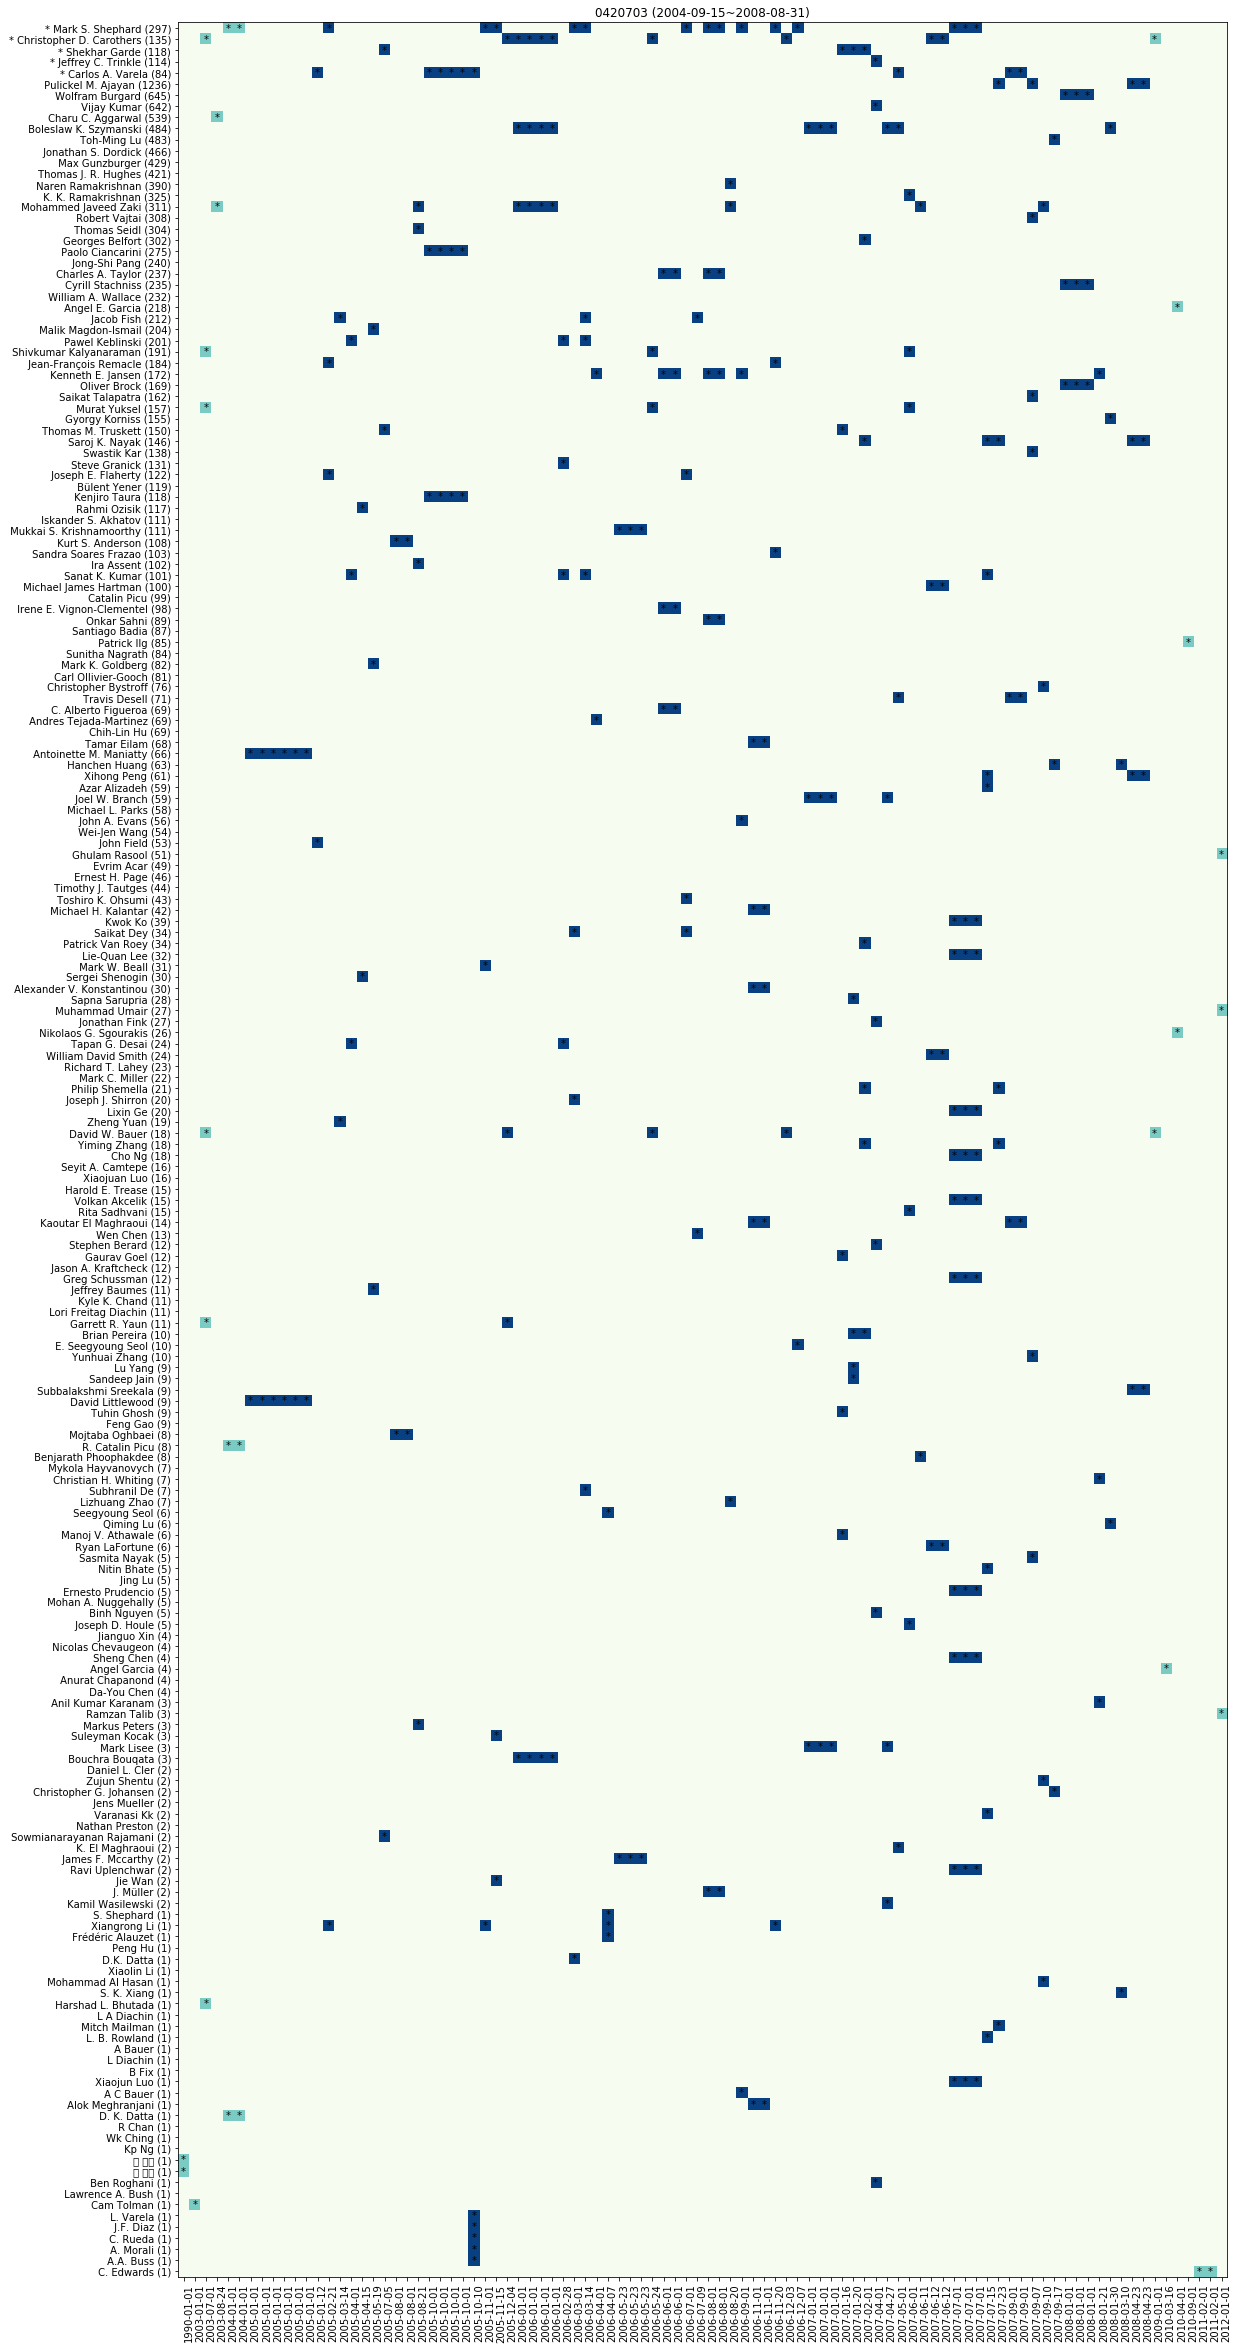

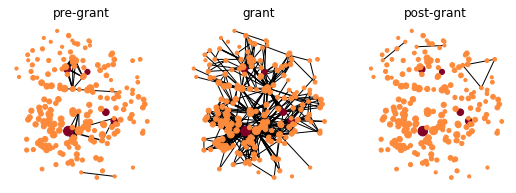

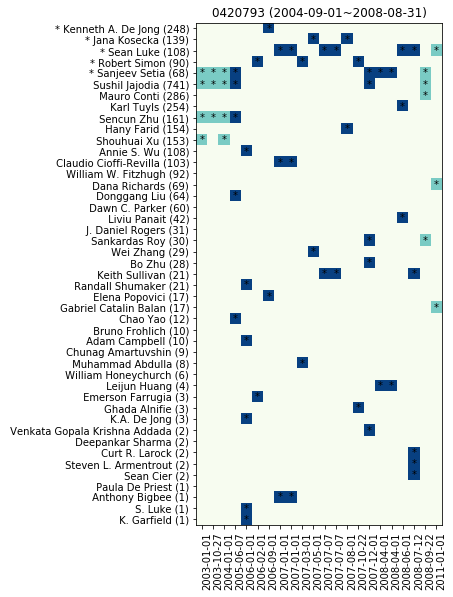

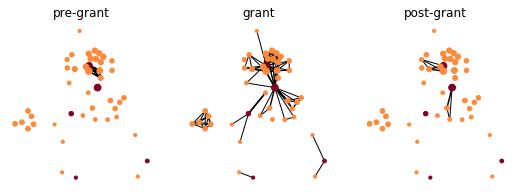

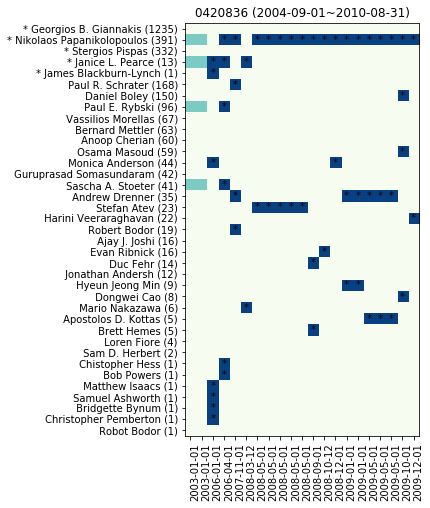

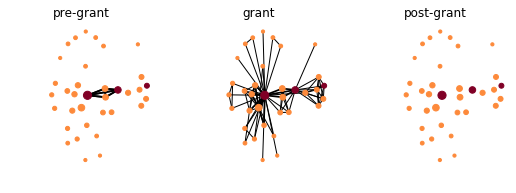

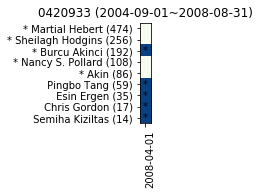

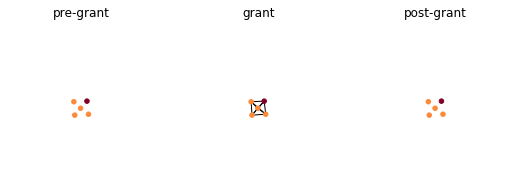

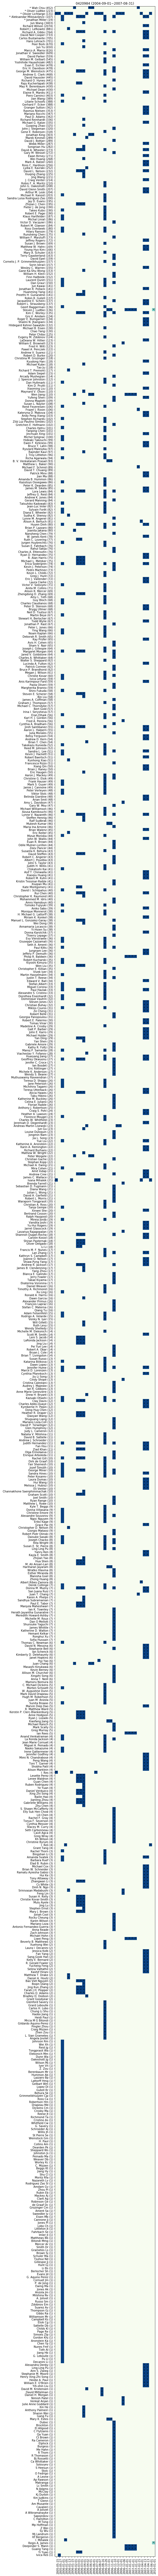

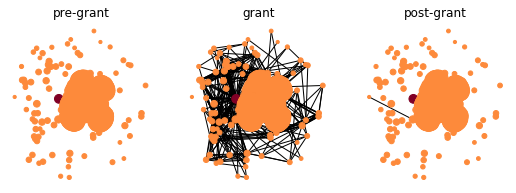

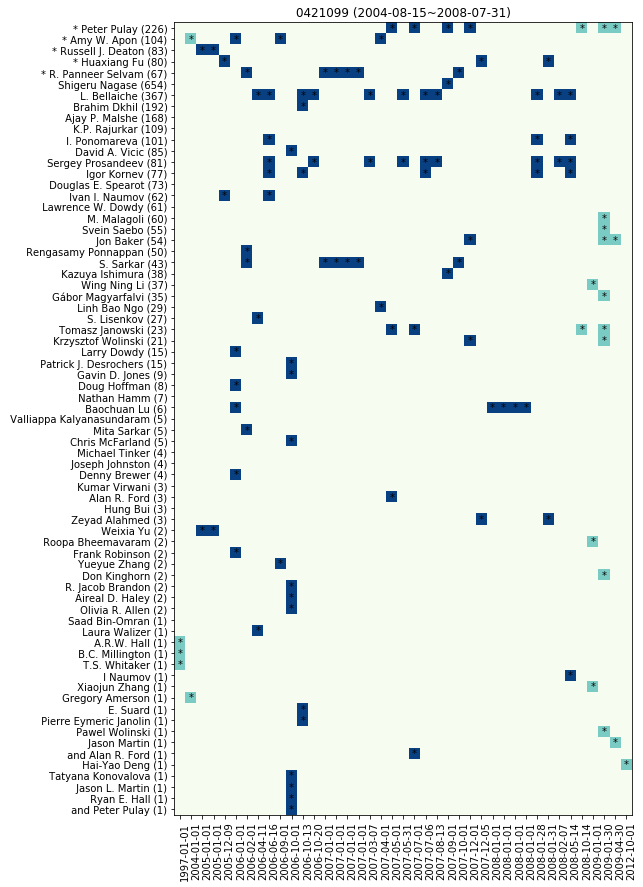

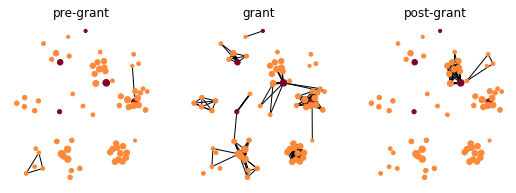

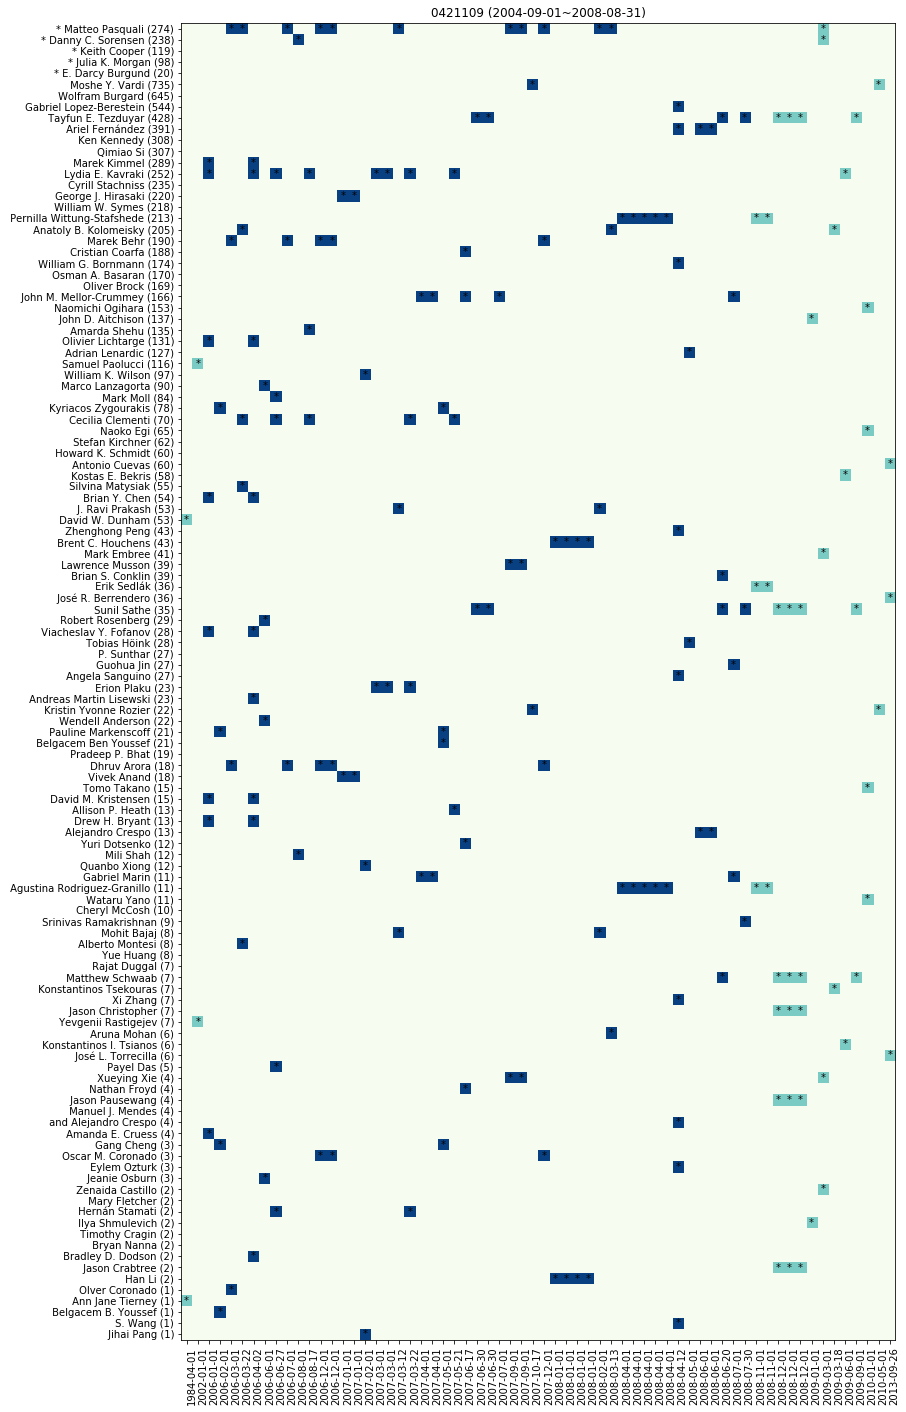

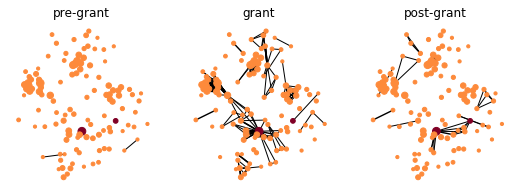

In [32]:
no_publications = []
for gid in grant_list[:20]:
    plot_coauthor_heatmap_paper(gid)